In [2]:
from pathlib import Path
import sys
relative_path = Path('model')
absolute_path = relative_path.resolve()
sys.path.append(str(absolute_path))

In [3]:
import torch
import pytorch_lightning as pl
from SGVB_SSM_TS_Clustering_Model_ResFlow import SGVB_SSM_TS_Clustering_Model_With_NF
from SIR_Toy_Dataset import SIR_Toy_Dataset
from torch import optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
base_param_dict_sir = {"input_dim":1,
                   "latent_dim":3,
                   "num_clusters":2,
                   "mode":"sir"}

lstm_param_dict = {"embed_hidden_dim":32,
                 "num_lstm_layers_base":2,
                 "num_lstm_layers_other":1,}

resflow_param_dict_sir = {"num_flow_module":4,
                      "kernel_size":2,
                      "dims" : [3, 32, 32, 32, 32, 3],
                      "bias" : True,
                      "coeff" : 0.9,
                      "n_iterations":None,
                      "tolerance":0.001,
                      "reduce_memory": False}


sir_model_param_dict={"c0":{"beta" : None,
                            "gamma" : None},
                      "c1":{"beta" : None,
                            "gamma" : None}}

sir_joint_prob_param_dict={"k_order" : None,
                           "lambda_order" : None,
                           "alpha_order" : None,
                           "init_SIR" : None}

trained_weight = "./weights/sir_trained_weight.pth"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
data_arr = np.load("data/sir_data.npz")
dataset = SIR_Toy_Dataset(data_arr, alldata=True)
dataloader = DataLoader(dataset, batch_size=45, shuffle=False)
batch = next(iter(dataloader))["I_obs"].to(device)

In [6]:
model = SGVB_SSM_TS_Clustering_Model_With_NF(base_param_dict=base_param_dict_sir,
                                                lstm_param_dict=lstm_param_dict,
                                                resflow_param_dict=resflow_param_dict_sir,
                                                model_param_dict=sir_model_param_dict,
                                                joint_prob_param_dict=sir_joint_prob_param_dict,
                                                GPU = torch.cuda.is_available()).to(device)
model(batch)
model.load_state_dict(torch.load(trained_weight))

<All keys matched successfully>

In [7]:
cluster_pred_list = []
cluster_gt_list = []
for batch in tqdm(dataloader):
    pred = model.lstm_embedder(batch["I_obs"].to(device))
    cluster_pred_list.append(np.argmax(pred["cluster"].cpu().detach().numpy(), axis=1))
    cluster_gt_list.append(batch["cluster"].numpy())
cluster_pred = np.concatenate(cluster_pred_list)
cluster_gt = np.concatenate(cluster_gt_list)

  0%|          | 0/14 [00:00<?, ?it/s]

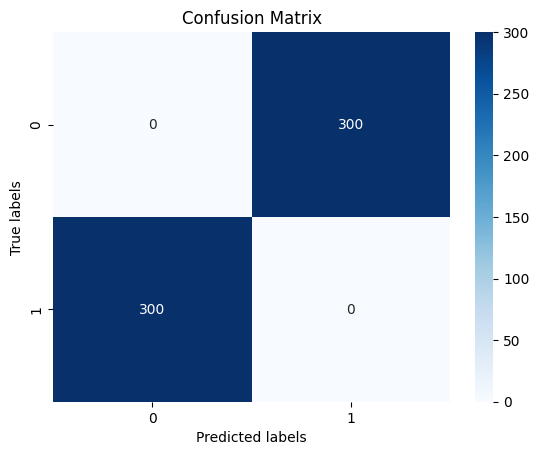

In [8]:
cm = confusion_matrix(cluster_gt, cluster_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()